In [43]:
import sys

import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt

sys.path.append("..")

import gc
import os
import subprocess
from collections.abc import Iterable
from glob import glob
from os.path import abspath, dirname, join
from statistics import mode
from pyproj import Transformer
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch.optim
from IPython.display import HTML, display
from joblib import Parallel, delayed
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter
from millify import millify
from PIL import Image
from scipy.ndimage import distance_transform_edt, gaussian_filter
from seaborn import color_palette
from skimage import transform
from skimage import measure
from skimage.color import label2rgb
# load label
from skimage.measure import find_contours, label
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage import data, color, morphology


from pred2raster import pred2raster
from sample_selection import *
from src.io_operations import (fix_relative_paths, load_args, read_tiff,
                               read_yaml)
from utils import *

In [44]:
sns.set_context("paper")
sns.set_style("whitegrid")

In [45]:
VERSION_FOLDER = "../13_amazon_data"
ITER_FOLDER = "iter_001"

In [46]:
id_tree = pd.read_csv(
    "../amazon_input_data/id_trees.csv"
).set_index("label_num")["tree_name"]

In [47]:
args = load_args(join(VERSION_FOLDER, 'args.yaml'))

In [48]:
ORTHOIMAGE = read_tiff(args.ortho_image)
ORTHOIMAGE = ORTHOIMAGE.transpose(1, 2, 0)

In [49]:
TRAIN_GT = read_tiff(args.train_segmentation_path)
TEST_GT = read_tiff(args.test_segmentation_path)

# TRAIN_GT += TEST_GT

In [74]:
train_metadata = get_image_metadata(args.train_segmentation_path)
orthoimage_metadata = get_image_metadata(args.ortho_image)

In [126]:
pixel_size_x = train_metadata["transform"][0]
pixel_size_y = -train_metadata["transform"][4]

In [52]:
def normalize_if_needed(image):
    if image.max() > 1.1:
        return image / 255
    return image

In [53]:
depth_pred = read_tiff(
    glob(join(VERSION_FOLDER, ITER_FOLDER, "raster_prediction", "depth*"))[0]
)

class_pred = read_tiff(
    glob(join(VERSION_FOLDER, ITER_FOLDER, "raster_prediction", "join_class*"))[0]
)
class_pred += 1

prob_pred = read_tiff(
    glob(join(VERSION_FOLDER, ITER_FOLDER, "raster_prediction", "join_prob*"))[0]
)

In [54]:
new_pred_map = filter_map_by_depth_prob(
    class_pred, 
    prob_pred, 
    depth_pred, 
    prob_thr=(args.prob_thr)*255, 
    depth_thr=(args.depth_thr)*255
)

In [55]:
filter_components_by_geometric_property(
    new_pred_map, 
    low_limit = np.float32(args.lower_limit_area), 
    high_limit = np.float32(args.upper_limit_area), 
    property = "area"
)

In [56]:
COMP_GT_TRAIN = label(TRAIN_GT)
comp_new_pred = label(new_pred_map)

new_pred_stats = get_components_stats(comp_new_pred, new_pred_map)
train_stats = get_components_stats(COMP_GT_TRAIN, TRAIN_GT)

train_stats["tree_name"] = train_stats["tree_type"].map(id_tree)
train_stats["area_m2"] = train_stats["area"] * pixel_size_x * pixel_size_y
new_pred_stats["area_m2"] = new_pred_stats["area"] * pixel_size_x * pixel_size_y

# Checando se a conversão de área está correta

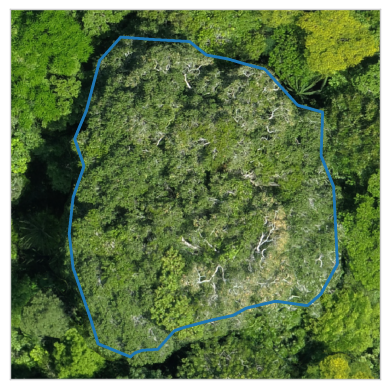

In [144]:
# Selecionando uma árvore de exemplo
selected_itc = train_stats[train_stats["tree_name"].str.contains("Rosa")].head(1)[["centroid-0", "centroid-1", "area_m2"]]
map_selected_itc = COMP_GT_TRAIN == selected_itc.index[0]

dim = 1000
window = (slice(int(selected_itc["centroid-0"].values[0]-dim//2), int(selected_itc["centroid-0"].values[0]+dim//2)), 
          slice(int(selected_itc["centroid-1"].values[0]-dim//2), int(selected_itc["centroid-1"].values[0]+dim//2)))

plt.imshow(ORTHOIMAGE[window])

for contour in find_contours(map_selected_itc[window], 0.5):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

In [145]:
with rasterio.open(args.train_segmentation_path) as src:

    transfomer = Transformer.from_crs(src.crs, "epsg:4326", always_xy=True)
    
    x, y = src.xy(selected_itc["centroid-0"].values[0], selected_itc["centroid-1"].values[0])
    
    x_coord, y_coord = transfomer.transform(x, y)    
    print(f"Localização da árvore: {y_coord},{x_coord}")
    print("Área da copa da árvore:", selected_itc["area_m2"].values[0], "m²")

Localização da árvore: -10.037251863073957,-67.68496121673597
Área da copa da árvore: 760.4671999997336 m²


Segundo o Google Earth, está correto!

Abiorana Rosa


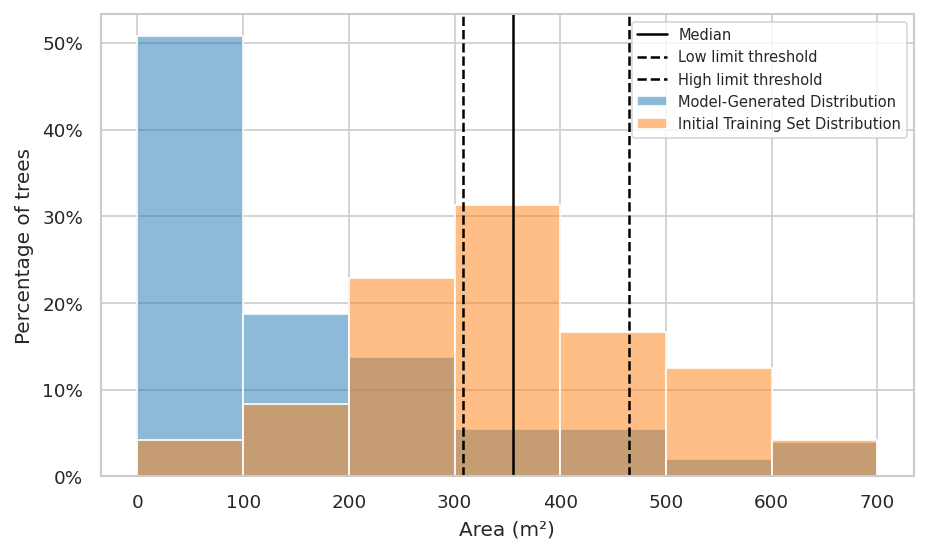

In [143]:

for tree_type_num in new_pred_stats["tree_type"].sort_values().unique():
    
    train_stats_area = train_stats[train_stats["tree_type"] == tree_type_num]["area"]* pixel_size_x * pixel_size_y
    new_pred_stats_area = new_pred_stats[new_pred_stats["tree_type"] == tree_type_num]["area"]* pixel_size_x * pixel_size_y
    
    
    median_train = train_stats_area.median() 
    
    low_thr = median_train + args.lower_limit_area_rlted_to_tree_type*median_train
    high_thr = median_train + args.upper_limit_area_rlted_to_tree_type*median_train
    
    var = train_stats_area.std()
    low_thr = median_train + args.lower_limit_area_rlted_to_tree_type*var
    high_thr = median_train + args.upper_limit_area_rlted_to_tree_type*var
    
    fig, ax = plt.subplots(figsize=(7, 4), dpi=150)
    # # plot histogram comparison
    sns.histplot(new_pred_stats_area,
                 bins=np.arange(0, 800, 100),
                 alpha=0.5, 
                 label="Model-Generated Distribution", 
                 stat="percent",
                 ax=ax)
    
    sns.histplot(train_stats_area, 
                 bins=np.arange(0, 800, 100),
                 alpha=0.5, 
                 label="Initial Training Set Distribution", 
                 stat="percent",
                 ax=ax)
    
    
    ax.axvline(median_train, color="black", linestyle="-", label="Median")
    ax.axvline(low_thr, color="black", linestyle="--", label="Low limit threshold")
    ax.axvline(high_thr, color="black", linestyle="--", label="High limit threshold")
    

    ax.set_xlabel("Area (m²)")
    ax.set_ylabel("Percentage of trees")
    
    # convert y ticks to percentage
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}%"))
    
    print(f"{id_tree[tree_type_num]}")
    
    plt.legend(loc='upper right', fontsize=7)
    # plt.savefig(
    #     f"figures/area_distribution_{id_tree[tree_type_num]}.png",
    #     dpi=120,
    #     bbox_inches="tight",
    # )
    plt.show()
    
    break

# Descobrindo a posição do Dataset em coordenadas

In [100]:
with rasterio.open(args.train_segmentation_path) as src:
    # Define the source CRS (UTM zone 19S) and target CRS (WGS 84)
    transformer = Transformer.from_crs("epsg:32719", "epsg:4326", always_xy=True)
    
    # Example: Transform the upper-left corner of the image
    ul_lon, ul_lat = transformer.transform(src.bounds.left, src.bounds.top)
    lr_lon, lr_lat = transformer.transform(src.bounds.right, src.bounds.bottom)
    
    print(f"The geographic coordinates of the upper-left corner are Longitude: {ul_lat},{ul_lon}")
    print(f"The geographic coordinates of the lower-right corner are Longitude: {lr_lat},{lr_lon}")
    # print all the corners
    
    top_left = transformer.transform(src.bounds.left, src.bounds.top)
    top_right = transformer.transform(src.bounds.right, src.bounds.top)
    bottom_left = transformer.transform(src.bounds.left, src.bounds.bottom)
    bottom_right = transformer.transform(src.bounds.right, src.bounds.bottom)
    
    # convert point (100,100) on image to coordinate
    x, y = 100, 100
    x, y = src.xy(x, y)
    print(transformer.transform(x, y))
    
    print(top_left[::-1])
    print(top_right[::-1])
    print(bottom_left[::-1])
    print(bottom_right[::-1])

The geographic coordinates of the upper-left corner are Longitude: -10.030588862913605,-67.69294583728929
The geographic coordinates of the lower-right corner are Longitude: -10.038783919147143,-67.67386066276532
(-67.69290901737492, -10.030625068058685)
(-10.030588862913605, -67.69294583728929)
(-10.030513274888333, -67.67389432187012)
(-10.038859570741751, -67.69291266141043)
(-10.038783919147143, -67.67386066276532)


In [139]:
biggest_tree_pos = tuple(train_stats.loc[22,["centroid-0", "centroid-1"]].values)
biggest_tree_pos = src.xy(*biggest_tree_pos)

biggest_tree_pos = transformer.transform(*biggest_tree_pos)
biggest_tree_pos[::-1]

(-10.03120336317126, -67.68781902565671)